In [2]:
import pickle
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot  as plt
import FinanceDataReader as fdr
import datetime

In [11]:
def date_add(date, month):
    '''date에 month만큼 더해준다. date는 20210102와 같은 꼴이나 datetime type으로 입력한다.'''
    if type(date) == str: # date가 datetime이 아니라 str 타입으로 들어온 경우
        date = datetime.strptime(date, '%Y%m%d')
    delta = timedelta(days=month*30.5)
    return date + delta

# print('date_add 함수 테스트 : {}'.format(date_add(date_start, 12)))


def earning_rate(stock_price : list, start_date, end_date):
    '''start_date부터 end_date까지 stock_price데이터를 가지고 수익률을 구해주는 함수(종가 기준)'''
    possible_start_date = stock_price[stock_price.index >= start_date].index[0]
    possible_end_date = stock_price[stock_price.index <= end_date].index[-1]
    
    start_price = stock_price.loc[possible_start_date].Close
    end_price = stock_price.loc[possible_end_date].Close
    
    return (end_price - start_price) / start_price

In [3]:
DATA_PATH = './db_and_model/stock_data_211210.csv'

def preprocess(data_path):
    """데이터 불러오기 + 전처리"""
    raw_data = pd.read_csv(DATA_PATH)
    raw_data.drop(raw_data[raw_data['PER'] == 0].index, inplace=True) # PER 0인 종목 제외
    raw_data.drop(raw_data[raw_data['PBR'] == 0].index, inplace=True) # PBR 0인 종목 제외

    return raw_data.reset_index()
    
raw_data = preprocess(DATA_PATH)
raw_data.describe()

,index,date,12개월 간 수익률,KOSPI 12개월 간 수익률,KOSPI대비 12개월 간 수익률,12개월 간 KOSPI 이김,PER,PBR,배당수익률,PER_inv,PBR_inv
count,978.000000,978.0,978.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000
mean,498.451943,20211210.0,0.369852,9.245610e-02,0.277396,0.537832,3041.021074,382.638456,1.151667,0.056235,0.731904
std,289.594006,0.0,0.925697,5.831653e-16,0.925697,0.498822,4677.862634,1908.048878,1.546083,0.132213,0.761036
min,0.000000,20211210.0,-0.823037,9.245610e-02,-0.915493,0.000000,0.330000,0.210000,0.000000,0.000026,0.000100
25%,247.250000,20211210.0,-0.087065,9.245610e-02,-0.179521,0.000000,14.245000,0.950000,0.000000,0.000100,0.202943
50%,496.500000,20211210.0,0.142295,9.245610e-02,0.049838,1.000000,33.885000,2.205000,0.575000,0.029512,0.453517
75%,749.750000,20211210.0,0.508415,9.245610e-02,0.415959,1.000000,10000.000000,4.927500,1.750000,0.070200,1.052632
max,999.000000,20211210.0,12.042169,9.245610e-02,11.949713,1.000000,38555.560000,10000.000000,15.590000,3.030303,4.761905


In [4]:
col_names = ["12개월 간 수익률", "KOSPI대비 12개월 간 수익률" , "12개월 간 KOSPI 이김" , 'PER_inv' , 'PBR_inv' , "배당수익률"]
X = raw_data[col_names]

In [5]:
MODEL_FILEPATH = './db_and_model/stock_pred_model.pkl'
with open(MODEL_FILEPATH, 'rb') as pickle_file:
    stock_pred_model = pickle.load(pickle_file)

C:\Users\mryoo\anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mryoo\anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mryoo\anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.0. This might lead to breaking code or invalid results.

In [6]:
y = stock_pred_model.predict_proba(X)[:, 1]
y = pd.DataFrame(y, columns=['y'])
y

,y
0,0.370441
1,0.563327
2,0.588051
3,0.442547
4,0.374133
...,...
973,0.358120
974,0.610166
975,0.304074
976,0.626029


In [7]:
# 결과 dataFrame
res = raw_data.copy()
res['y'] = y.values

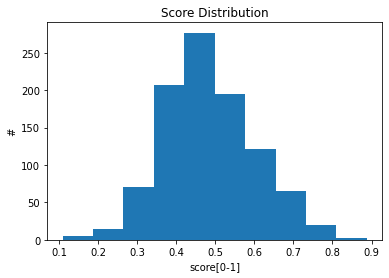

In [8]:
fig = plt.figure()
plt.hist(res['y'])
plt.title('Score Distribution')
plt.xlabel('score[0-1]')
plt.ylabel('#')
plt.show()

In [54]:
top_stocks = res.sort_values(by='y', ascending=True).head(200)

start_date = '20211210'
today = '20220325'

stock_price_dic = {}

# KOSPI = fdr.DataReader('KS11', start=start_date) # 이거 왜 오류나냐

for code in top_stocks.code:
    stock_price_dic[code] = fdr.DataReader(code, start=start_date)
# sample = stock_price_dic['024110']
# sample.head()

In [55]:
er_list = []
for code in top_stocks.code:
    er = earning_rate(stock_price_dic[code], start_date, today)
    er_list.append(er)

top_stocks['수익률'] = er_list
top_stocks.head()

,index,date,code,12개월 간 수익률,name,KOSPI 12개월 간 수익률,KOSPI대비 12개월 간 수익률,12개월 간 KOSPI 이김,PER,PBR,배당수익률,PER_inv,PBR_inv,y,수익률
727,744,20211210,205500,3.208451,액션스퀘어,0.092456,3.115995,1,10000.00,16.79,0.00,0.000100,0.059559,0.109179,-0.459170
113,114,20211210,298050,3.673401,효성첨단소재,0.092456,3.580945,1,38555.56,9.94,0.00,0.000026,0.100604,0.128288,-0.304035
240,243,20211210,289220,3.507578,자이언트스텝,0.092456,3.415122,1,10000.00,69.49,0.00,0.000100,0.014391,0.130824,-0.195219
315,322,20211210,003580,2.921933,넥스트사이언스,0.092456,2.829477,1,10000.00,10.48,0.00,0.000100,0.095420,0.136623,-0.305687
57,57,20211210,066970,2.906650,엘앤에프,0.092456,2.814194,1,10000.00,30.89,0.02,0.000100,0.032373,0.157700,-0.026226


In [56]:
top_stocks['수익률'].mean()*100

-6.590237929030933

In [16]:
earning_rate(sample, start_date, '20220325')

-0.0045662100456621

In [143]:
code

'009580'

In [104]:
help(fdr.DataReader)

Help on function DataReader in module FinanceDataReader.data:

DataReader(symbol, start=None, end=None, exchange=None, data_source=None)
    read price data from various exchanges or data source
    * symbol: code or ticker
    * start, end: date time string
    * exchange: 'KRX'(default), 'KRX-DELISTING', 'NYSE', 'NASDAQ', 'AMEX', 'SSE', 'SZSE', 'HKEX', 'TSE', 'HOSE'
    * data_source: 'FRED'

